# Simulate a cluster with ocelot

> ⚠ This feature is currently only available for simulating clusters in Gaia DR3 with PARSEC isochrones. More data types will be added soon!

Ocelot includes many utilities for simulating clusters. They are designed to be flexible and 'hackable' for any science case!

Let's quickly demonstrate how it works.

## Setup

Firstly, we'll need to import the relevant parts of the library.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
from astropy import units as u
from astroquery.gaia import Gaia
import pyvo
from ocelot.simulate import (
    SimulatedCluster,
    SimulatedClusterParameters,
    SimulatedClusterModels,
)
from ocelot.model.observation import (
    GaiaDR3ObservationModel,
    GenericSubsampleSelectionFunction,
)

We'll write a little function to plot our clusters:

In [2]:
def plot_on_axes(
    ax, stars: pd.DataFrame, xlabel: str, ylabel: str, scatter_kwargs: dict
):
    ax.scatter(stars[xlabel], stars[ylabel], **scatter_kwargs)
    ax.set(xlabel=xlabel, ylabel=ylabel)
    ax.minorticks_on()


def plot_simulated_cluster(
    cluster: SimulatedCluster, observation: str = None, **kwargs
):
    fig, ax = plt.subplots(ncols=4, figsize=(12, 3))

    if observation is None:
        stars = cluster.cluster
        x_cmd = "temperature"
        y_cmd = "luminosity"
        ax[3].invert_xaxis()
        ax[3].set(xscale="log", yscale="log")
    else:
        stars = cluster.observations[observation]
        stars["bp_rp"] = stars["gaia_dr3_bp"] - stars["gaia_dr3_rp"]
        x_cmd = "bp_rp"
        y_cmd = "gaia_dr3_g"
        ax[3].invert_yaxis()

    # stars["bp_rp"] = (
    #     stars["phot_bp_mean_mag"] - stars["phot_rp_mean_mag"]
    # )
    scatter_kwargs = dict(s=1, color="k")
    scatter_kwargs.update(kwargs)
    plot_on_axes(ax[0], stars, "l", "b", scatter_kwargs)
    plot_on_axes(ax[1], stars, "pmra", "pmdec", scatter_kwargs)
    plot_on_axes(ax[2], stars, "l", "parallax", scatter_kwargs)
    plot_on_axes(ax[3], stars, x_cmd, y_cmd, scatter_kwargs)
    fig.tight_layout()
    return fig, ax

## Specifying cluster parameters

ocelot stores parameters about a simulated cluster internally with a class called `SimulatedClusterParameters`. You don't have to, but you can specify a new `SimulatedCluster` with this parameter class.

This has the added bonus that the parameters for your cluster are fully type hinted!

To start, your cluster will need a position **with full 3D position and velocity information,** specified as an astropy SkyCoord.

In [3]:
position = SkyCoord(
    ra=45 * u.deg,
    dec=0 * u.deg,
    distance=1000 * u.pc,
    pm_ra_cosdec=10 * u.mas / u.yr,
    pm_dec=0 * u.mas / u.yr,
    radial_velocity=0 * u.km / u.s,
    frame="icrs",
)

We can then plug this position (and other parameters!) into the SimulatedClusterParameters class.

In [4]:
parameters = SimulatedClusterParameters(
    position=position,
    mass=1000,
    log_age=8.0,
    metallicity=0.2,
    extinction=0.5,
    r_core=2,
    r_tidal=10,
    # By default, ocelot also tries to add a lot more realism to simulated clusters.
    # We'll turn it off for now so that we can demonstrate how it works later!
    photometric_errors=False,
    astrometric_errors=False,
    selection_effects=False,
    binary_stars=False,
)

## A basic simulated cluster

Simulating a cluster with these parameters is as easy as doing:

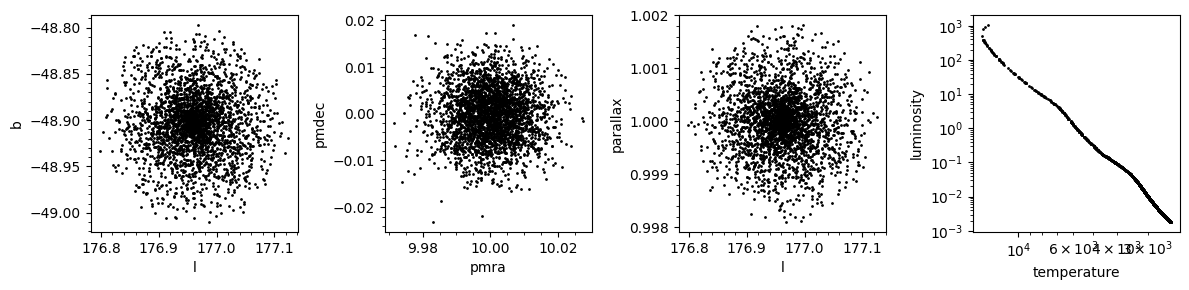

In [5]:
cluster = SimulatedCluster(random_seed=42, parameters=parameters)
cluster.make()
_ = plot_simulated_cluster(cluster)

This successfully simulates the _true_ positions, luminosities, and temperatures of stars in a simulated cluster. Great!

Note that ocelot also forces you to set a random seed for reproducibility.

The real challenge is to work out what their _observed_ properties would actually be. This requires two more features that are the real chunky parts of `ocelot.simulate`:

1. Pairing stars into binaries
2. Simulating an astrometric & photometric observation.

## Adding in binary stars

In [6]:
parameters = SimulatedClusterParameters(
    position=position,
    mass=100,
    log_age=8.0,
    metallicity=0.2,
    extinction=0.5,
    r_core=2,
    r_tidal=10,
    photometric_errors=False,
    astrometric_errors=False,
    selection_effects=False,
)

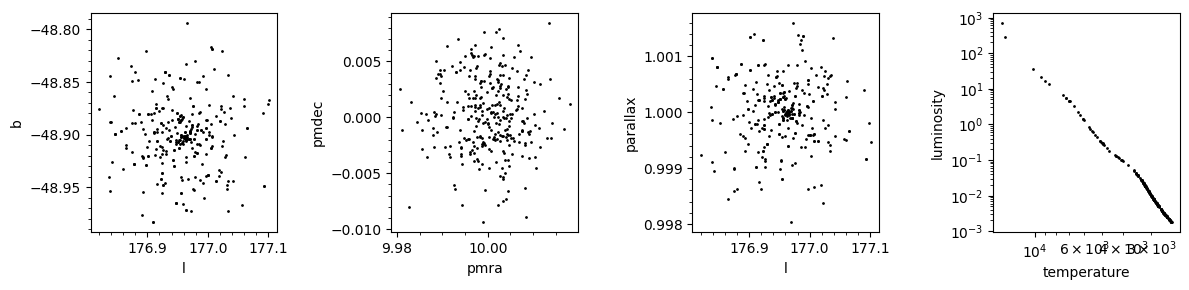

In [7]:
cluster = SimulatedCluster(random_seed=42, parameters=parameters)
cluster.make()
_ = plot_simulated_cluster(cluster)

This code stochastically pairs stars into binaries. (It takes a bit longer to run the first time, as the code uses `numba` to compile some parts of the binary star code.)

For now, just one binary star relation is implemented - the [Moe+17](https://ui.adsabs.harvard.edu/abs/2017ApJS..230...15M/abstract) relationships.

Some of the stars are now paired together into binaries - look at the few that are in pairs in the l/b diagram! It's a little bit hard to see here, as we're still simulating a perfect cluster observed by a perfect telescope with infinite resolving power, so we don't (yet) simulate a sequence of clear unresolved binaries on the cluster's CMD.

The next step is to simulate a real observation with a real telescope!

## Simulating an observation

The real power of ocelot comes from how we can simulate what a telescope would see if it looked at a cluster.

Let's simulate a Gaia observation. Currently, to estimate errors, this also means we need a bit of Gaia data to base our error distribution on:

In [8]:
Gaia.ROW_LIMIT = 100000
query = Gaia.cone_search(parameters.position, radius=0.5 * u.deg)
gaia_data = query.get_results().to_pandas().rename(columns={"SOURCE_ID": "source_id"})

Next, we need to define a model for our observation.

In [9]:
models = SimulatedClusterModels(
    observations=[GaiaDR3ObservationModel(representative_stars=gaia_data)]
)

We now just pass this data to `SimulatedCluster.make` and it will handle the rest:

In [10]:
parameters = SimulatedClusterParameters(
    position=position,
    mass=1000,
    log_age=8.0,
    metallicity=0.2,
    extinction=0.5,
    r_core=2,
    r_tidal=10,
)

Total number of stars: 0


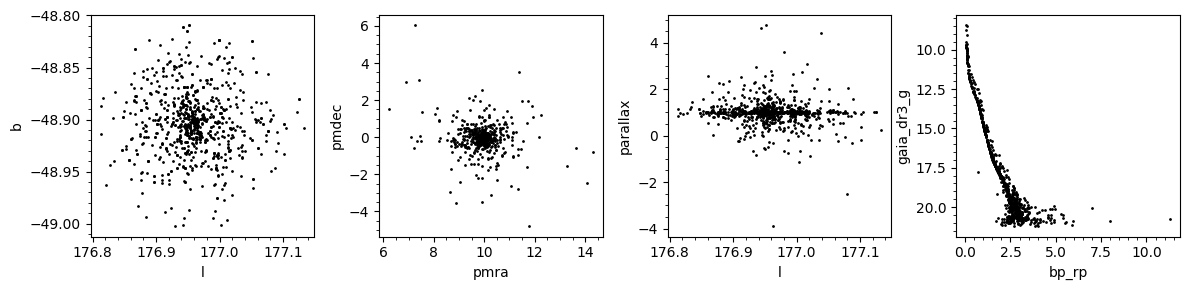

In [11]:
cluster = SimulatedCluster(random_seed=42, parameters=parameters, models=models)
cluster.make()
_ = plot_simulated_cluster(cluster, observation="gaia_dr3")
print("Total number of stars:", cluster.parameters.n_stars)

A few things have now happened behind the scenes to make this look like a Gaia observation of this cluster:

1. We've simulated photometry for the cluster.
2. Using an estimate of the telescope's resolving power, we've converted some binary stars into unresolved binaries (visible as a binary sequence on the right-hand side.)
3. We've used our sample of Gaia data to apply astrometric and photometric errors to the cluster.
4. The Gaia selection function (i.e. a probabilistic magnitude limit) was applied to the cluster, using the method in [Cantat-Gaudin+23](https://ui.adsabs.harvard.edu/abs/2023A%26A...669A..55C/abstract).

This goes a long way towards what a real cluster looks like in Gaia data. However, a number of (predominantly fainter) stars in Gaia do not have proper motions and parallaxes; some have unreliable astrometry; and others have missing BP and RP colour magnitudes.

We can go one step further, and account for the _subsample selection effects_ that would cause an observed cluster to contain fewer stars.

## Accounting for subsample selection effects

Internally, ocelot uses the method from [Rix+21](https://ui.adsabs.harvard.edu/abs/2021AJ....162..142R/abstract) & [Castro-Ginard+23](https://ui.adsabs.harvard.edu/abs/2023A%26A...677A..37C/abstract) to model the probability that a given star would (or would not) be resolved in a subsample of a dataset.

As a simple example, let's define a subset of our Gaia data that contains:

1. Proper motions and parallaxes
2. G, BP, and RP photometry
3. A RUWE (renormalised weight error) greater than 1.4.
4. Only stars greater than magnitude 19.

In [21]:
gaia_data_subsample = gaia_data.loc[
    np.logical_and.reduce(
        (
            gaia_data["astrometric_params_solved"] >= 31,
            gaia_data["phot_g_mean_mag"].notna(),
            gaia_data["phot_bp_mean_mag"].notna(),
            gaia_data["phot_rp_mean_mag"].notna(),
            gaia_data["ruwe"] < 1.4,
            gaia_data["phot_g_mean_mag"] < 19,
        )
    )
]
print(
    f"Fraction of stars in subsample: {len(gaia_data_subsample) / len(gaia_data):.2f}"
)

Fraction of stars in subsample: 0.40


Naively, our observed cluster should contain just 40% as many stars - most of which will be at the faint end.

We can make a subsample quite easily, and ocelot has a class for that. We just need to pass it these two dataframes and the key we want to use (in this case, "phot_g_mean_mag" for the data, and "gaia_dr3_g" for the cluster.)

In [22]:
subsample_sf = GenericSubsampleSelectionFunction(
    gaia_data, gaia_data_subsample, "gaia_dr3_g", column_in_data="phot_g_mean_mag"
)

We can even take a quick look at what this selection function looks like.

In [23]:
# Todo make plot

And now, finally, here is our realistic final cluster:

In [25]:
models = SimulatedClusterModels(
    observations=[
        GaiaDR3ObservationModel(
            representative_stars=gaia_data, subsample_selection_functions=[subsample_sf]
        )
    ]
)

Total number of stars: 0


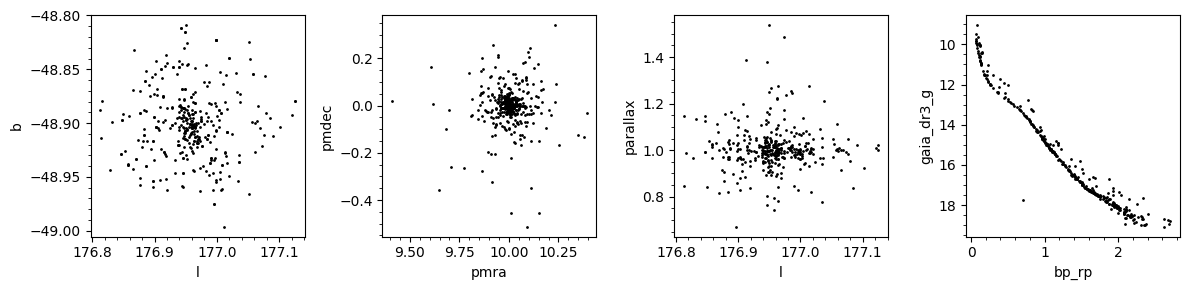

In [26]:
cluster = SimulatedCluster(random_seed=42, parameters=parameters, models=models)
cluster.make()
_ = plot_simulated_cluster(cluster, observation="gaia_dr3")
print("Total number of stars:", cluster.parameters.n_stars)

Notice how there are **far fewer stars** than before applying the selection effects. In addition, the scatter in proper motion and parallax is a lot lower, as we've removed a lot of faint sources that (if Gaia even could measure their proper motion and parallax) would have very high uncertainty.

Compare it to the full cluster membership list:

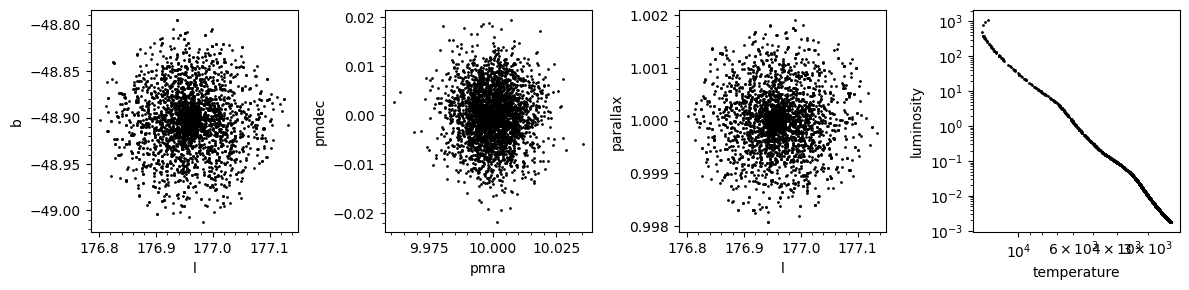

In [27]:
_ = plot_simulated_cluster(cluster)

Unsurprisingly, many stars are missing from Gaia for a cluster that's 1000 parsecs away.

## Other cool things

Finally, it's worth going through a few other features.

1. The SimulatedClusterParameters object can be easily converted to a dictionary for saving.

In [28]:
parameters.to_dict()

{'position': <SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, pc)
     (45., 0., 1000.)
  (pm_ra_cosdec, pm_dec, radial_velocity) in (mas / yr, mas / yr, km / s)
     (10., 0., 0.)>,
 'mass': 1000,
 'log_age': 8.0,
 'metallicity': 0.2,
 'r_core': 2,
 'r_tidal': 10,
 'extinction': 0.5,
 'differential_extinction': 0.0,
 'minimum_stars': 1,
 'virial_ratio': 0.5,
 'velocity_dispersion_1d': 727.4726445111436,
 'eta_virial_ratio': 10.0,
 'photometric_errors': True,
 'astrometric_errors': True,
 'astrometric_errors_scale_factor': 1.0,
 'selection_effects': True,
 'visible_stars_only': True,
 'binary_stars': True,
 'binary_star_relation': ocelot.model.binaries.moe_distefano_17.MoeDiStefanoMultiplicityRelation,
 'id': 0,
 'r_50': 0.8126953124999965,
 'n_stars': 0,
 'ra': 45.0,
 'dec': 0.0,
 'l': 176.96129125564056,
 'b': -48.90264433846198,
 'distance': 1000.0,
 'pmra': 10.0,
 'pmdec': 0.0,
 'radial_velocity': 0.0}

In [19]:
from ocelot.model.differential_reddening import FractalDifferentialReddening

In [20]:
diff = FractalDifferentialReddening(seed=42)

In [23]:
cluster_reference_frame = cluster.parameters.position.skyoffset_frame()

In [33]:
cluster_coords = SkyCoord(
    ra=cluster.cluster["ra"].to_numpy() * u.deg,
    dec=cluster.cluster["dec"].to_numpy() * u.deg,
    distance=(1000 / cluster.cluster["parallax_true"].to_numpy()) * u.pc,
).transform_to(cluster_reference_frame)
cartesian = cluster_coords.cartesian

In [22]:
cluster.cluster.columns

Index(['simulated_id', 'cluster_id', 'simulated_star', 'mass_initial', 'mass',
       't_eff', 'log_g', 'g_true', 'bp_true', 'rp_true', 'a_g', 'a_bp', 'a_rp',
       'companions', 'g_flux', 'bp_flux', 'rp_flux', 'index_primary',
       'matching_star_id', 'phot_g_mean_flux_error', 'phot_bp_mean_flux_error',
       'phot_rp_mean_flux_error', 'pmra_error', 'pmdec_error',
       'parallax_error', 'phot_g_mean_mag', 'phot_bp_mean_mag',
       'phot_rp_mean_mag', 'ra', 'dec', 'l', 'b', 'pmra', 'pmdec', 'parallax',
       'pmra_true', 'pmdec_true', 'parallax_true', 'radial_velocity_true',
       'bp_rp'],
      dtype='object')

In [ ]:
diff.extinction()

## DELETE LATER: TESTING

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from ocelot.simulate import SimulatedCluster, SimulatedClusterParameters
from astropy.coordinates import SkyCoord
from astropy import units as u
from astroquery.gaia import Gaia
import pyvo

In [4]:
def plot_on_axes(
    ax, cluster: SimulatedCluster, xlabel: str, ylabel: str, scatter_kwargs: dict
):
    ax.scatter(cluster.cluster[xlabel], cluster.cluster[ylabel], **scatter_kwargs)
    ax.set(xlabel=xlabel, ylabel=ylabel)
    ax.minorticks_on()


def plot_simulated_cluster(cluster: SimulatedCluster, **kwargs):
    fig, ax = plt.subplots(ncols=4, figsize=(12, 3))
    cluster.cluster["bp_rp"] = (
        cluster.cluster["phot_bp_mean_mag"] - cluster.cluster["phot_rp_mean_mag"]
    )
    scatter_kwargs = dict(s=1, color="k")
    scatter_kwargs.update(kwargs)
    plot_on_axes(ax[0], cluster, "l", "b", scatter_kwargs)
    plot_on_axes(ax[1], cluster, "pmra", "pmdec", scatter_kwargs)
    plot_on_axes(ax[2], cluster, "l", "parallax", scatter_kwargs)
    plot_on_axes(ax[3], cluster, "bp_rp", "phot_g_mean_mag", scatter_kwargs)
    ax[3].invert_yaxis()
    fig.tight_layout()
    return fig, ax

In [5]:
position = SkyCoord(
    ra=45 * u.deg,
    dec=0 * u.deg,
    distance=1000 * u.pc,
    pm_ra_cosdec=10 * u.mas / u.yr,
    pm_dec=0 * u.mas / u.yr,
    radial_velocity=0 * u.km / u.s,
    frame="icrs",
)

In [22]:
parameters = SimulatedClusterParameters(
    position=position,
    mass=1000,
    log_age=8.0,
    metallicity=0.2,
    extinction=0.5,
    r_core=2,
    r_tidal=10,
    # By default, ocelot also tries to add a lot more realism to simulated clusters.
    # We'll turn it off for now so that we can demonstrate how it works later!
    photometric_errors=False,
    astrometric_errors=False,
    selection_effects=False,
    binary_stars=False,
)

In [30]:
cluster = SimulatedCluster(random_seed=42, parameters=parameters)
cluster.make_cluster()
# _ = plot_simulated_cluster(cluster)

,simulated_id,cluster_id,simulated_star,mass_initial,mass,t_eff,log_g,g_true,bp_true,rp_true,...,dec,l,b,pmra,pmdec,parallax,pmra_true,pmdec_true,parallax_true,radial_velocity_true
0,0,0,True,0.065991,0.065991,NaN,NaN,NaN,NaN,NaN,...,-0.239024,177.375618,-48.964027,10.006145,-0.002436,1.000238,10.006145,-0.002436,1.000238,0.102676
1,1,0,True,0.055374,0.055374,NaN,NaN,NaN,NaN,NaN,...,0.156577,176.841314,-48.758988,9.968190,-0.010892,0.996762,9.968190,-0.010892,0.996762,0.046059
2,2,0,True,0.042353,0.042353,NaN,NaN,NaN,NaN,NaN,...,-0.062699,177.017433,-48.954737,9.999009,-0.001332,0.999845,9.999009,-0.001332,0.999845,-0.011590
3,3,0,True,0.035980,0.035980,NaN,NaN,NaN,NaN,NaN,...,0.109447,176.444027,-49.095406,9.987718,0.006310,0.998672,9.987718,0.006310,0.998672,-0.309780
4,4,0,True,0.036500,0.036500,NaN,NaN,NaN,NaN,NaN,...,-0.012732,176.587523,-49.174125,10.028983,0.004452,1.003166,10.028983,0.004452,1.003166,-0.309648
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3060,3060,0,True,0.712270,0.711949,4414.486043,4.657223,17.055503,17.743181,16.254171,...,-0.015600,177.029556,-48.878497,9.997368,0.004111,0.998972,9.997368,0.004111,0.998972,0.046217
3061,3061,0,True,0.891085,0.890297,5129.144331,4.607048,15.791887,16.256781,15.163803,...,0.040847,176.918575,-48.872925,9.979314,-0.007563,0.998286,9.979314,-0.007563,0.998286,-0.006518
3062,3062,0,True,0.754260,0.754294,4601.538254,4.670979,16.758792,17.372361,16.008960,...,0.041486,176.988123,-48.824493,10.015444,-0.003763,1.001563,10.015444,-0.003763,1.001563,0.052711
3063,3063,0,True,3.676150,3.672343,13079.219684,4.098195,9.750913,9.693083,9.857657,...,-0.072266,177.045261,-48.949531,10.003890,-0.007516,1.000858,10.003890,-0.007516,1.000858,0.021913
